# Script for calculating metric "Cappilary loop count"

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.models import load_model
import tensorflow as tf
import SimpleITK as sitk
from skimage.transform import resize
from scipy import ndimage
import cv2
from skimage import filters, measure, morphology
import math



## functions

In [76]:
# import the dicom file from the folder 
def import_dicom(path):
    # read the dicom file
    dicom_image = sitk.ReadImage(path)
    # get the pixel array
    image = sitk.GetArrayFromImage(dicom_image)
    spacing = dicom_image.GetSpacing()
    return image, spacing 

def plot_image_side_by_side(image1, image2, title1, title2):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    plt.show()

def test_model_on_sample_image(model, image, plot=True):

    # Add channel dimension if image is grayscale
    img = tf.expand_dims(image, axis=-1) if image.ndim == 2 else image

    # Explicitly cast the image tensor to float32
    img = tf.cast(img, tf.float32)
    # Resize the image to (256, 256)
    img = tf.image.resize(img, (256, 256))

    # Normalize the image to [0, 1]
    img = img / 65535.0  # Since your image is uint16, normalize by 65535 instead of 255

    # Add batch dimension
    img = tf.expand_dims(img, axis=0)

    # Make predictions using the model
    pred_mask = model.predict(img)
    pred_mask = tf.squeeze(pred_mask, axis=0)  # Remove batch dimension
    pred_mask = tf.round(pred_mask)  # Binarize the predicted mask
    
    # Resize the predicted mask to 460x1355
    resized_mask = tf.image.resize(pred_mask, (460, 1355))
    resized_mask = tf.squeeze(resized_mask, axis=-1)  # Remove the last dimension
    
    # Load and resize the original image to 460x1355 (keeping 3 channels for RGB display)
    original_img = tf.image.resize(tf.squeeze(img, axis=0), (460, 1355))  # Remove batch dimension but keep the channel
    original_img = tf.repeat(original_img, 3, axis=-1)  # Convert to 3 channels for RGB
    
    # Convert mask to red overlay
    red_mask = np.zeros((460, 1355, 3))  # Initialize a black image with 3 channels
    red_mask[:, :, 0] = resized_mask  # Assign the mask to the red channel
    
    # Overlay the red mask on the original image
    overlayed_img = np.clip(original_img + red_mask, 0, 1)  # Ensure the values are in [0, 1] range

    if plot:
        # Plot the original image and mask overlay
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(tf.squeeze(original_img), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_img)
        plt.title('OCT image with Epidermis Mask Overlay')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    return resized_mask
def remove_epidermis_from_image(image, p_mask, plot=True):
    # Align dimensions of mask and image
    if p_mask.shape[1] != image.shape[1]:
        from skimage.transform import resize
        p_mask = resize(p_mask, (p_mask.shape[0], image.shape[1]), anti_aliasing=True, order=0)

    # Find the row indices for the upper and lower lines
    upper_line = np.argmax(p_mask, axis=0)
    lower_line = p_mask.shape[0] - np.argmax(np.flipud(p_mask), axis=0) - 1

    # Create the coordinates for the upper and lower lines
    cols = np.arange(p_mask.shape[1])  # x coordinates (columns)
    upper_coords = np.column_stack((upper_line, cols))
    lower_coords = np.column_stack((lower_line, cols))

    # Create a copy of the image to avoid modifying the original
    img_modified = image.copy()

    # Loop through each column (ensure bounds are correct)
    min_width = min(image.shape[1], upper_line.shape[0])
    for col in range(min_width):
        upper_y = int(upper_line[col])  # Convert float to int for indexing
        img_modified[:upper_y, col] = 0  # Set pixels above the upper line to 0 (black)

    img_modified[p_mask == 1] = 0  # Set all pixels in the mask area to 0

    if plot:
        # Plot the original and modified image with lines
        plt.figure(figsize=(20, 5))
        plt.imshow(image, cmap='gray')
        plt.plot(upper_coords[:, 1], upper_coords[:, 0], color='red', label='Skin surface')
        plt.plot(lower_coords[:, 1], lower_coords[:, 0], color='blue', label='Dermal-Epidermal Junction (DEJ)')
        plt.legend()
        plt.title('Image with smoothed surface and DEJ lines')
        plt.show()

        # Plot the modified image
        plt.figure(figsize=(20, 5))
        plt.title('Image with epidermis removed (Smoothed)')
        plt.imshow(img_modified, cmap='gray')
        plt.show()

    return img_modified, upper_coords, lower_coords



def shift_line_coordinates(line_coords, shift_amount, img_height):
    """
    Shift the y-coordinates of the line down by a specified number of pixels.
    
    Parameters:
    - line_coords: Array of (y, x) coordinates representing the current line.
    - shift_amount: Number of pixels to shift the line down.
    - img_height: The height of the image (so that the new line does not exceed the image boundaries).
    
    Returns:
    - new_coords: The new coordinates shifted down.
    """
    # Copy the coordinates to avoid modifying the original
    new_coords = line_coords.copy()

    # Shift the y-coordinates (rows) by the specified amount
    new_coords[:, 0] = new_coords[:, 0] + shift_amount
    
    # Ensure the new y-coordinates do not go beyond the image height
    new_coords[:, 0] = np.clip(new_coords[:, 0], 0, img_height - 1)

    return new_coords

def create_mask_between_lines(img_height, img_width, upper_coords, lower_coords):
    """
    Create a binary mask for the area between two lines.

    Parameters:
    - img_height: The height of the image (or mask).
    - img_width: The width of the image (or mask).
    - upper_coords: Array of (y, x) coordinates representing the upper line.
    - lower_coords: Array of (y, x) coordinates representing the lower line.

    Returns:
    - mask: A binary mask of shape (img_height, img_width) where 1 represents the area between the two lines.
    """
    # Initialize an empty mask with zeros
    mask = np.zeros((img_height, img_width), dtype=np.uint8)

    # Iterate over each column (x-coordinates)
    for col in range(img_width):
        # Get the row index (y-coordinates) for the upper and lower lines at the current column
        upper_y = int(upper_coords[col, 0])  # Upper line y-coordinate
        lower_y = int(lower_coords[col, 0])  # Lower line y-coordinate

        # Set the mask to 1 between the upper and lower lines in this column
        if upper_y < lower_y:
            mask[upper_y:lower_y+1, col] = 1  # Fill the area between the lines

    return mask

def capillary_loop_analysis(oct_image,octa_image,model):
    epidermis_mask = test_model_on_sample_image(model, oct_image, plot=False)
    modified_image, upper_line, lower_line = remove_epidermis_from_image(oct_image,epidermis_mask, plot=False)
    new_lower = shift_line_coordinates(lower_line, 20, oct_image.shape[0])
    mask_papillay_dermis = create_mask_between_lines(oct_image.shape[0], oct_image.shape[1], lower_line, new_lower)
    OCTA_papillary_derma = np.where(mask_papillay_dermis == 1, octa_image, 0)
    papillary_dermis_area = np.sum(mask_papillay_dermis)
    papillary_dermis_intensity = np.sum(OCTA_papillary_derma)
    capillary = np.where(OCTA_papillary_derma > 0, 1, 0)
    capillary_area = np.sum(capillary)
    vessel_density = capillary_area / papillary_dermis_area * 100 
    average_intensity = papillary_dermis_intensity / papillary_dermis_area

    # print(f'Papillary Dermis Area: {papillary_dermis_area}')
    # print(f'Papillary Dermis Intensity: {papillary_dermis_intensity}')
    # print(f'Average Intensity in Papillary Dermis: {average_intensity}')
    # print(f'capillary Area: {capillary_area}')
    print(f'vessel density: {vessel_density}')
        
def calculate_tortuosity(coords):
    """
    Calculate the tortuosity of a line given its coordinates.

    Parameters:
    - coords: A numpy array of shape (n_points, n_dimensions),
                where n_dimensions is 2 for 2D or 3 for 3D coordinates.

    Returns:
    - tortuosity: A float representing the tortuosity of the line.
    """
    coords = np.asarray(coords)
    n_points, n_dimensions = coords.shape

    if n_points < 2:
        raise ValueError("At least two points are required to calculate tortuosity.")

    # Calculate the actual path length (L)
    # Compute the distances between consecutive points
    diffs = np.diff(coords, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    L = np.sum(segment_lengths)

    # Calculate the straight-line distance (D)
    D = np.linalg.norm(coords[-1] - coords[0])

    if D == 0:
        raise ValueError("The start and end points are the same. Tortuosity is undefined.")

    # Calculate tortuosity
    tortuosity = L / D

    return tortuosity


def identify_and_plot_dots(image, min_size=50, intensity_threshold = 50,dot_color='red', dot_alpha=0.5, plot=True, circularity_threshold=0.7):
    # Keep a copy of the original image for plotting
    original_image = image.copy()

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image[image < intensity_threshold] = 0

   

    # Convert to binary (0 and 1)   
    binary_image = np.where(image > 0, 1, 0)
    
    # Remove small objects (noise) and fill small holes
    cleaned_image = morphology.remove_small_objects(binary_image.astype(bool), min_size=min_size)


    # Label connected components
    labeled_image = measure.label(cleaned_image)

    # Create an empty image to store only circular objects
    circular_objects = np.zeros_like(labeled_image)

    # Get properties of labeled regions
    regions = measure.regionprops(labeled_image)

    # Collect coordinates of dots that are sufficiently circular
    dot_coords = []
    for region in regions:
        if region.perimeter == 0:  # Avoid division by zero
            continue
        # Calculate circularity
        circularity = 4 * math.pi * region.area / (region.perimeter ** 2)
        if circularity >= circularity_threshold:
            dot_coords.append(region.centroid)
            # Keep the circular object in the circular_objects image
            circular_objects[labeled_image == region.label] = 1
        # Else: do nothing, effectively removing the non-circular region

    # Convert circular_objects to binary image
    circular_objects = circular_objects > 0

    # Plotting
    if plot:
        plt.figure(figsize=(12, 12))
        plt.imshow(circular_objects, cmap='gray')
        # y_coords, x_coords = zip(*dot_coords) if dot_coords else ([], [])
        # plt.scatter(x_coords, y_coords, c=dot_color, alpha=dot_alpha)
        plt.title(f'Identified Dots (min size = {min_size}, circularity ≥ {circularity_threshold})')
        plt.axis('off')
        plt.show()

        # Plot the image with only circular objects
        plt.figure(figsize=(12, 12))
        # plot the cleaned image on top of the original image
        plt.imshow(original_image, cmap='gray')
       
        plt.imshow(circular_objects, cmap='hot', alpha=dot_alpha)
        plt.title('MIP with identified dots')
        plt.show()

    return dot_coords, circular_objects



## Code

1/1 [==============================] - 0s 450ms/step


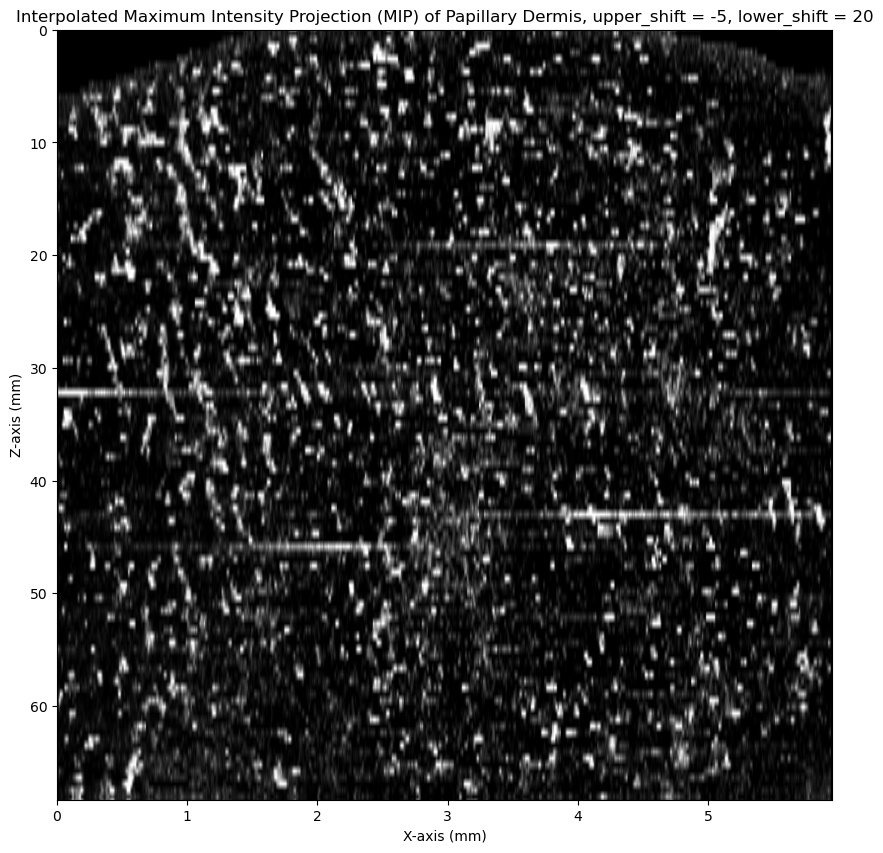

1.3322366763953728


In [91]:
model = load_model('C:/Users/Madsl/Desktop/DTU/Bachelor_data/epidermus_segmenter_mark1/epidermus_segmenter_mark1.h5')
# model2 = load_model('C:/Users/Madsl/Dropbox/DTU/Bachelor_proj/epidermus_segmenter_mark1/epidermus_segmenter_mark2.h5')

OCTA_folder_path = r"D:\DTU\Bachelor_data\CAPtest\Capcaisin\CAPtest_04_07_11_2024\CAPtest_04_Left Leg_CAPtest_04_ After\CAPtest_04_Left Leg_CAPtest_04_Cap After_S281_07_11_2024\CAPtest_04_Left Leg_CAPtest_04_Cap After_S281_07_11_2024_D.dcm"
OCT_folder_path = r"D:\DTU\Bachelor_data\CAPtest\Capcaisin\CAPtest_04_07_11_2024\CAPtest_04_Left Leg_CAPtest_04_ After\CAPtest_04_Left Leg_CAPtest_04_Cap After_S281_07_11_2024\CAPtest_04_Left Leg_CAPtest_04_Cap After_S281_07_11_2024_S.dcm"

OCTA_data, spacing =  import_dicom(OCTA_folder_path)
OCT_data,_ =  import_dicom(OCT_folder_path)
x_spacing, y_spacing, z_spacing = spacing

papillary_dermis_3d = np.zeros_like(OCTA_data)

upper_shift = -5
lower_shift = 20

tortuosities = np.zeros(OCTA_data.shape[0])

for i in range(OCTA_data.shape[0]):
    oct_img_1 = OCT_data[i,:,:]
    octa_img_1 = OCTA_data[i,:,:]
    p_mask = test_model_on_sample_image(model, oct_img_1,plot=False)
    modified_image, upper_line, lower_line = remove_epidermis_from_image(oct_img_1, p_mask, plot=False)
    new_lower = shift_line_coordinates(lower_line, lower_shift, oct_img_1.shape[0])
    new_upper = shift_line_coordinates(lower_line, upper_shift, oct_img_1.shape[0])
    mask_papillay_dermis = create_mask_between_lines(oct_img_1.shape[0], oct_img_1.shape[1], new_upper, new_lower)
    OCTA_papillary_derma = np.where(mask_papillay_dermis == 1, octa_img_1, 0)
    papillary_dermis_3d[i,:,:] = OCTA_papillary_derma
    tortuosities[i] = calculate_tortuosity(lower_line)


papillary_dermis_mip = np.max(papillary_dermis_3d, axis=1)

# Interpolated MIP of papillary dermis
mip = resize(papillary_dermis_mip, (1355, 1355), anti_aliasing=True, order=1)


# Apply the spacing
x_length = mip.shape[1] * x_spacing  # Total width in mm
z_length = mip.shape[0] * z_spacing  # Total depth in mm

# Flip and rotate the image
# mip = np.rot90(mip)
# mip = np.flipud(mip)
# Plot with a square figure size
fig_size = 10  # Adjust this as needed for display size
plt.figure(figsize=(fig_size, fig_size))
plt.imshow(mip, cmap='gray', extent=[0, x_length, z_length, 0], aspect='auto')
plt.title(f'Interpolated Maximum Intensity Projection (MIP) of Papillary Dermis, upper_shift = {upper_shift}, lower_shift = {lower_shift}')
plt.xlabel("X-axis (mm)")
plt.ylabel("Z-axis (mm)")
plt.show()

print(np.mean(tortuosities))


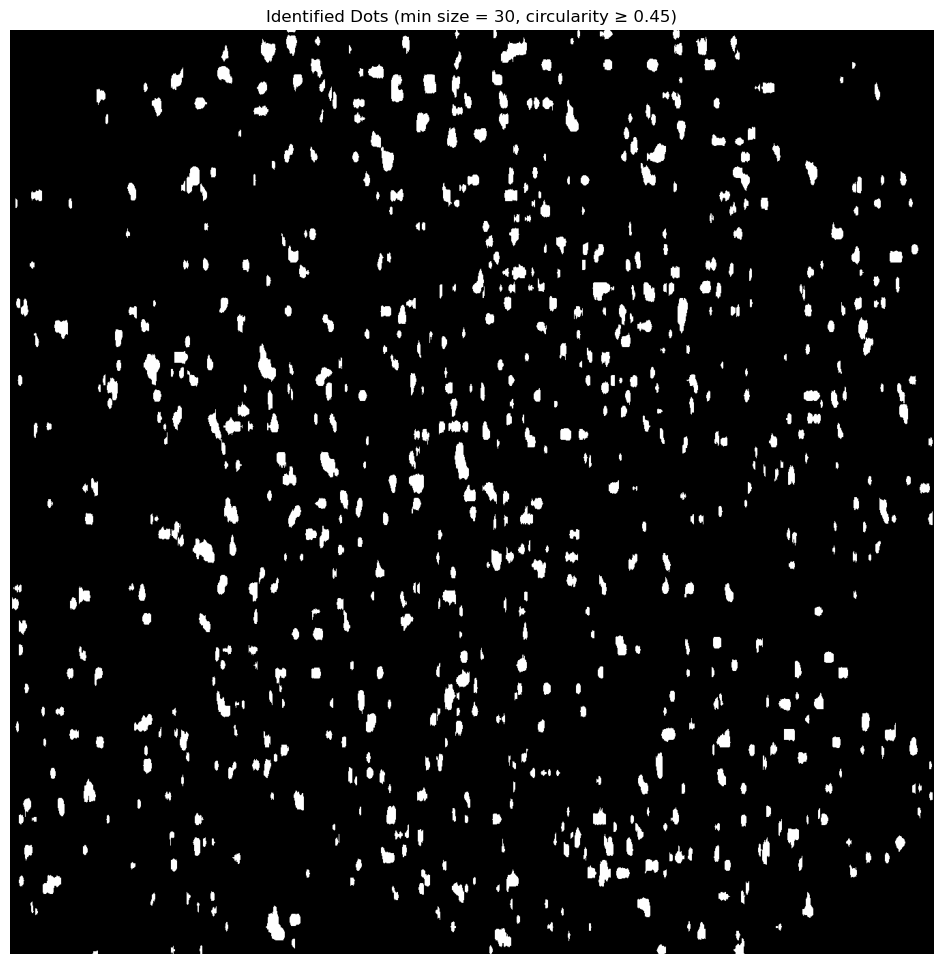

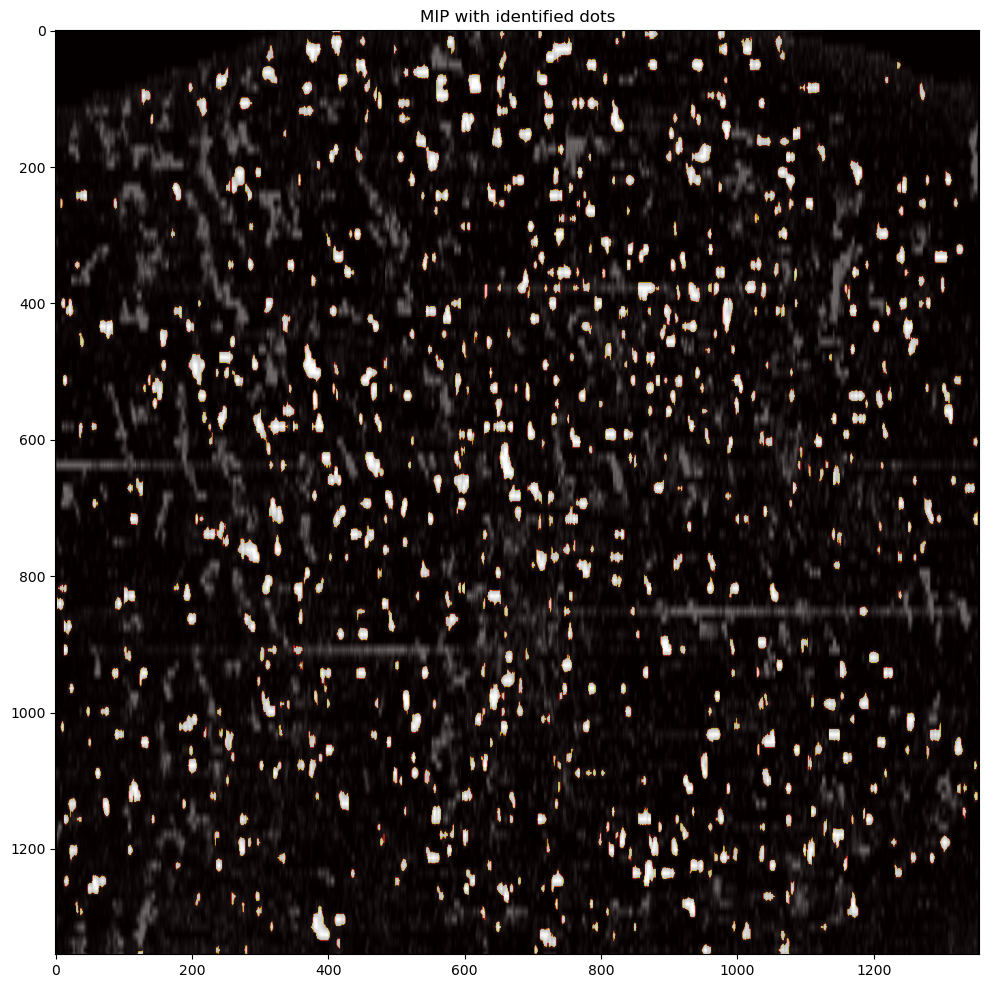

Number of dots identified: 764
Dot area: 108142
Dot area ratio: 0.17


In [92]:

# Example usage:
dot_coords, cleaned_img = identify_and_plot_dots(mip, min_size=30,  intensity_threshold = 75, dot_color='red', dot_alpha=0.6, plot=True, circularity_threshold=0.45)

# print the number of dots identified
print(f'Number of dots identified: {len(dot_coords)}')

# calculate the combined area of the dots
dot_area = np.sum(np.where(cleaned_img>0,1,0))
print(f'Dot area: {dot_area}')

# calculate the dot area over the total area of the image
total_area = octa_img_1.shape[0] * octa_img_1.shape[1]
dot_area_ratio = dot_area / total_area
print(f'Dot area ratio: {dot_area_ratio :.2f}')

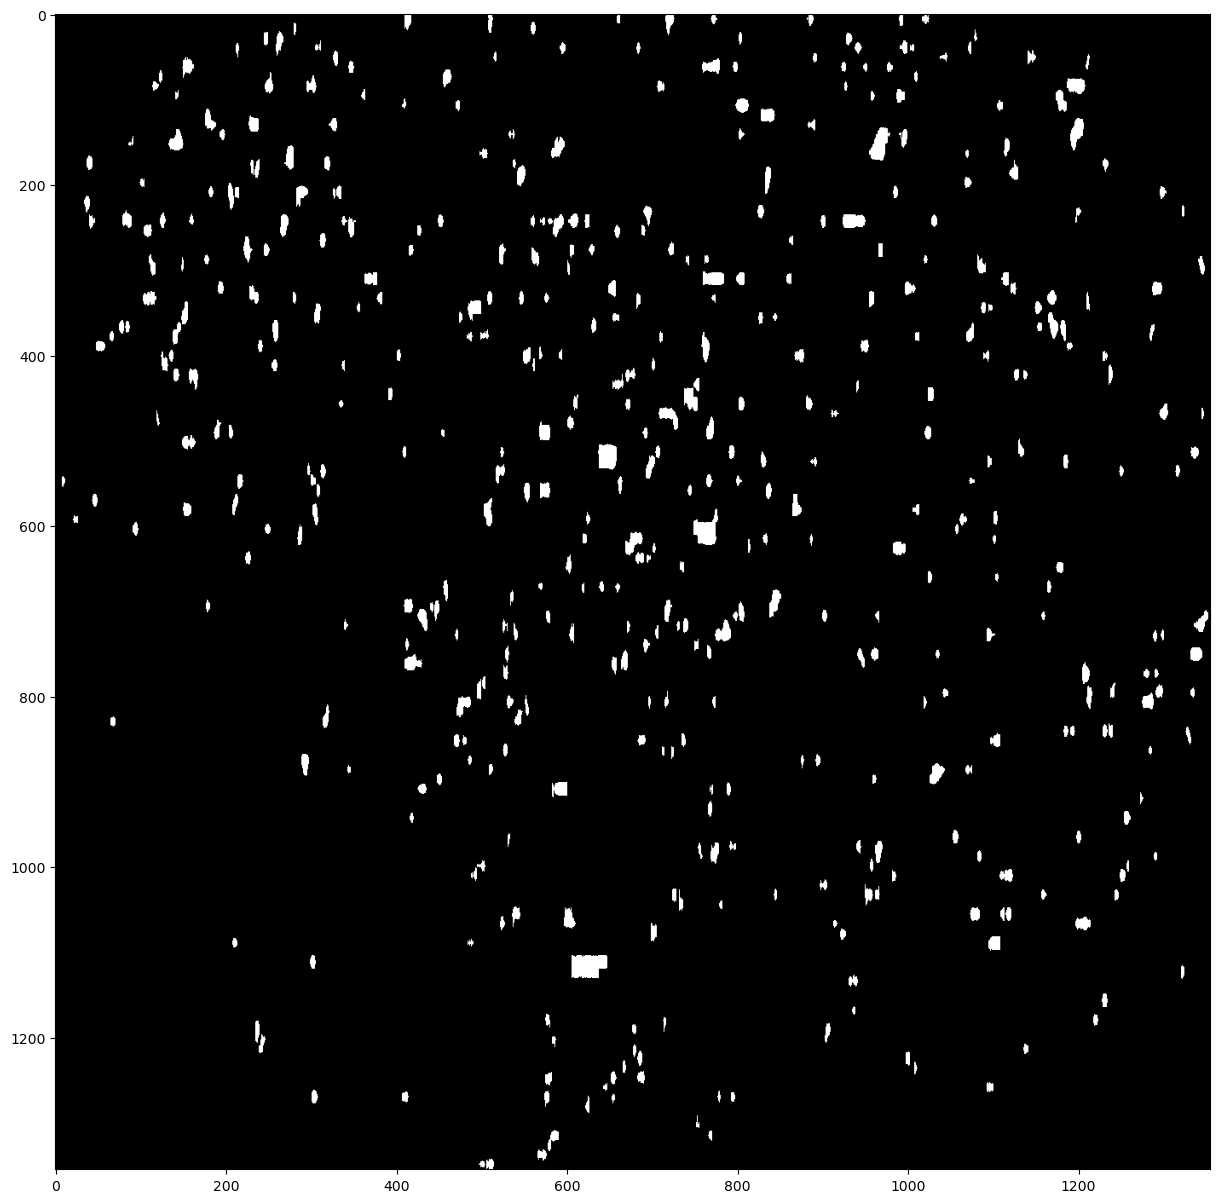

In [50]:
plt.figure(figsize=(15, 15))
plt.imshow(cleaned_img, cmap='gray')
plt.show()
